The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.adjusters.force_inference import infer_forces
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale

Error: IPOPT shared library failed to import


Using TensorFlow backend.


Reseting datasets values with new specs
Reseting datasets values with new specs


0


Reseting datasets values with new specs


1


Reseting datasets values with new specs


2


Reseting datasets values with new specs


3


Reseting datasets values with new specs


4


Reseting datasets values with new specs


5


Reseting datasets values with new specs


6


Reseting datasets values with new specs


7


Reseting datasets values with new specs


8
9


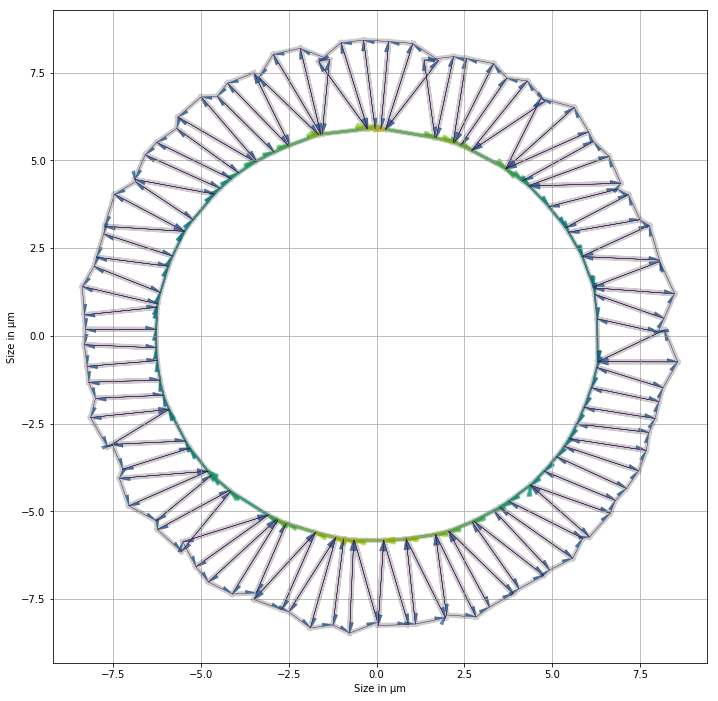

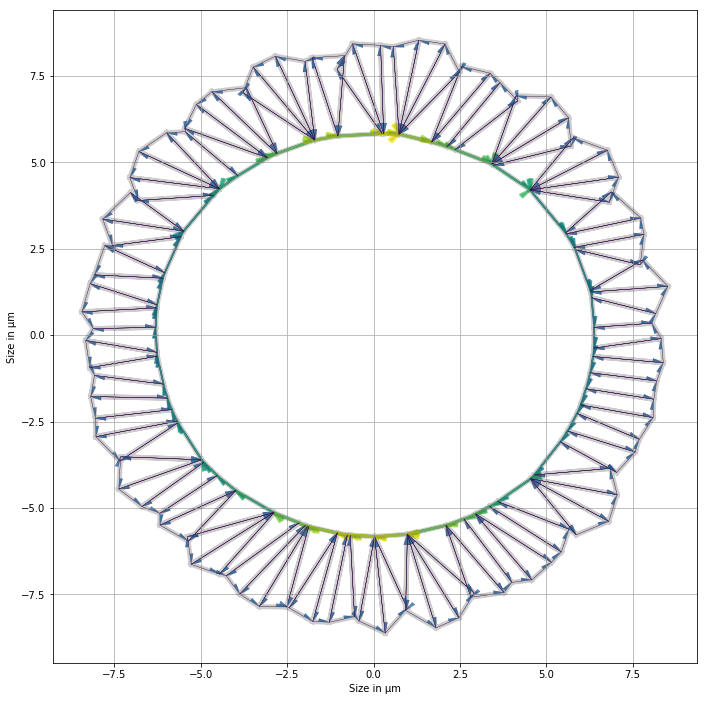

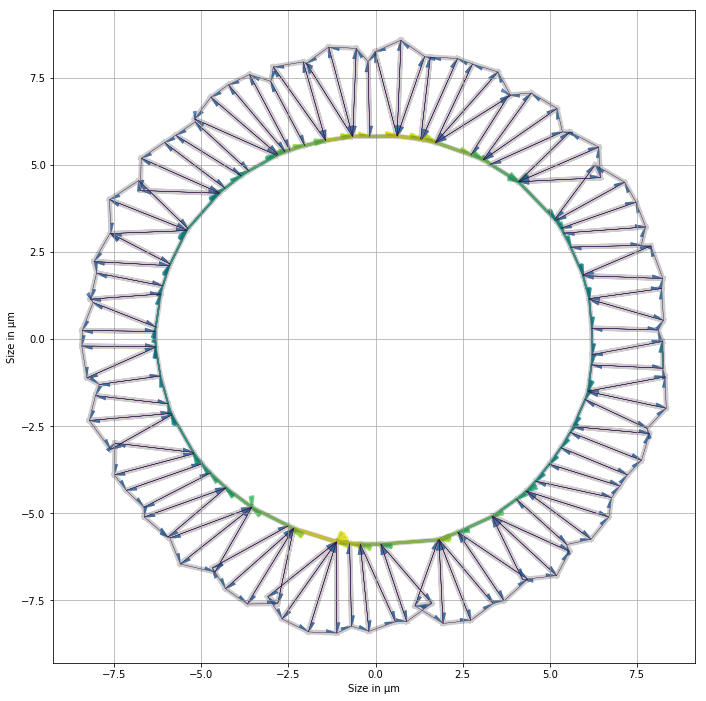

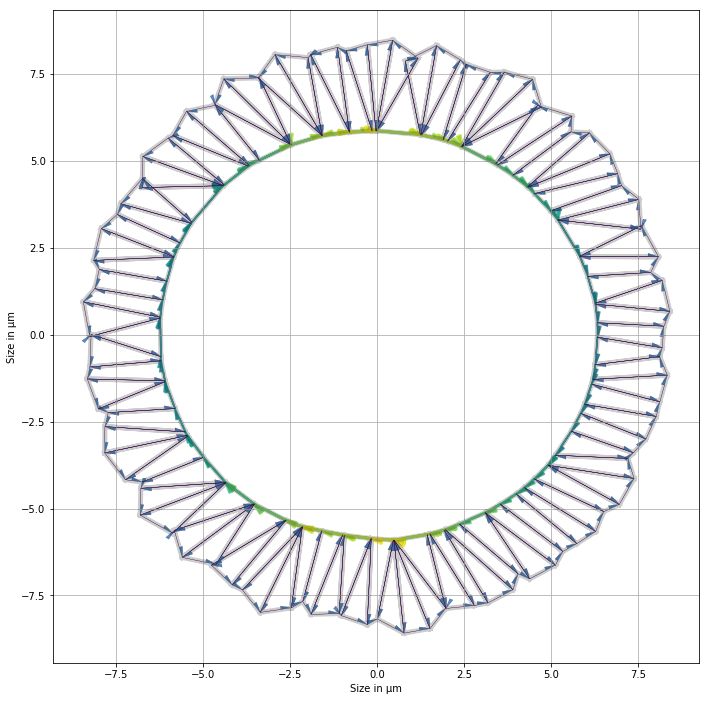

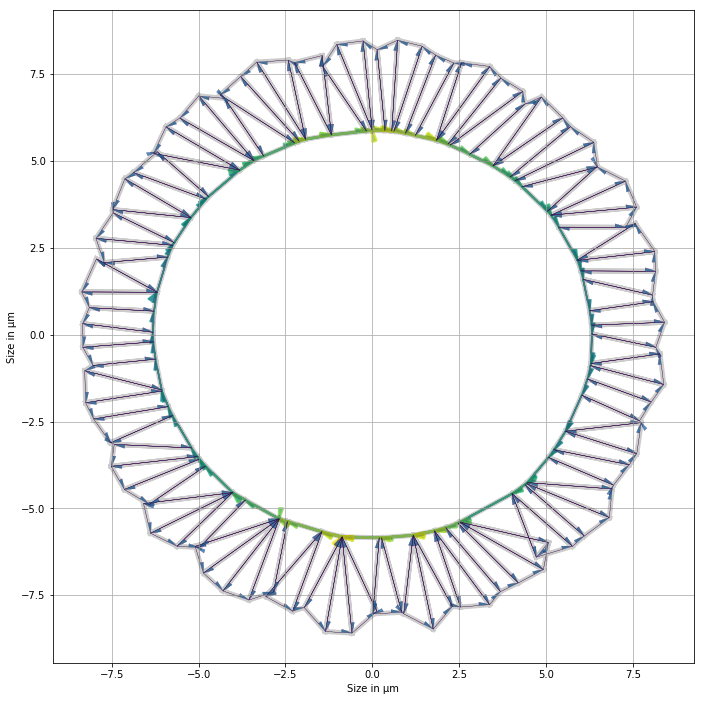

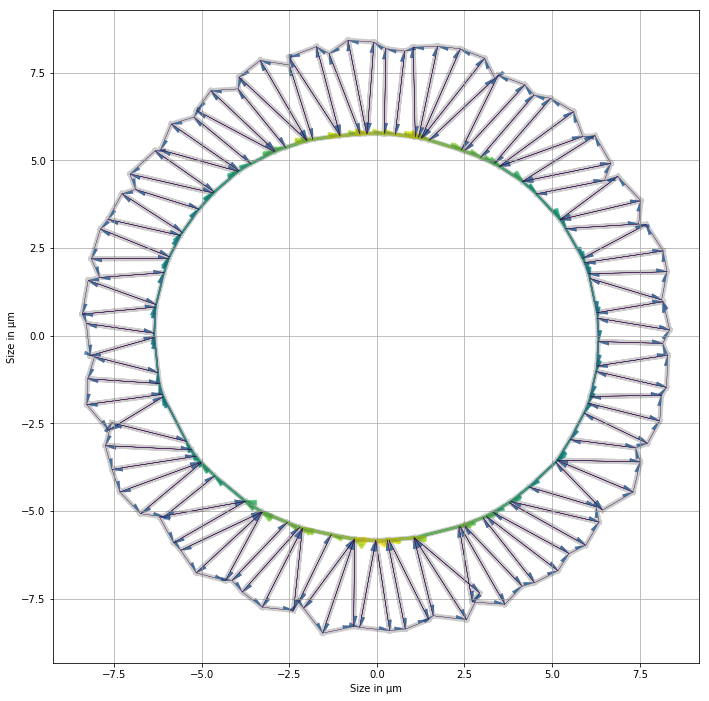

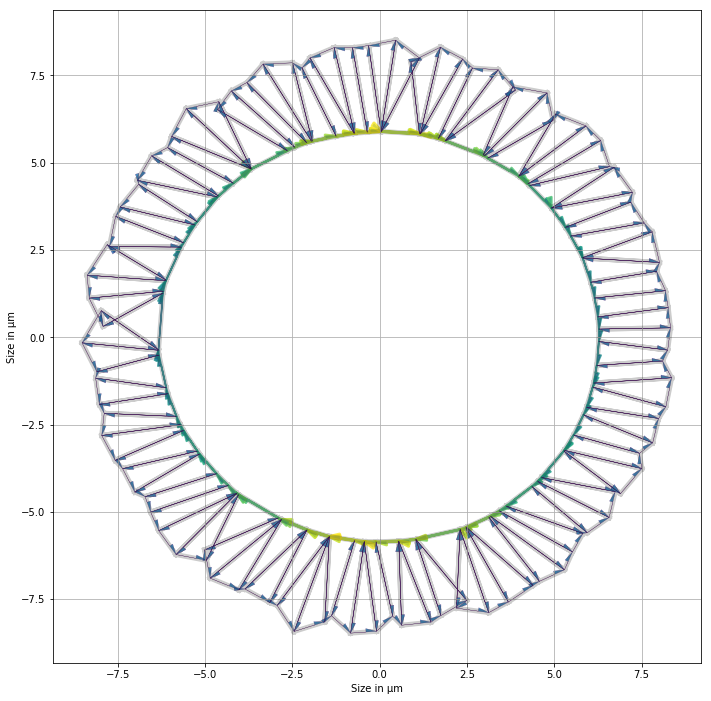

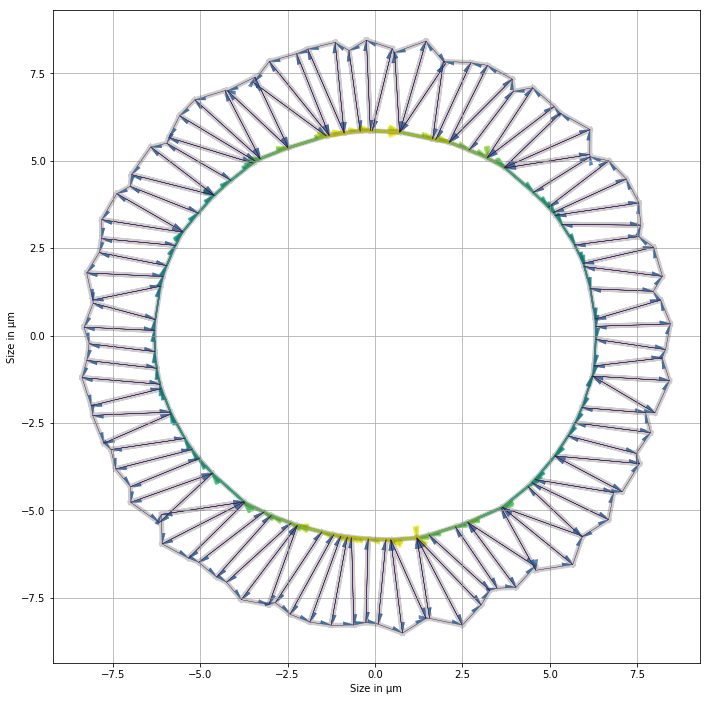

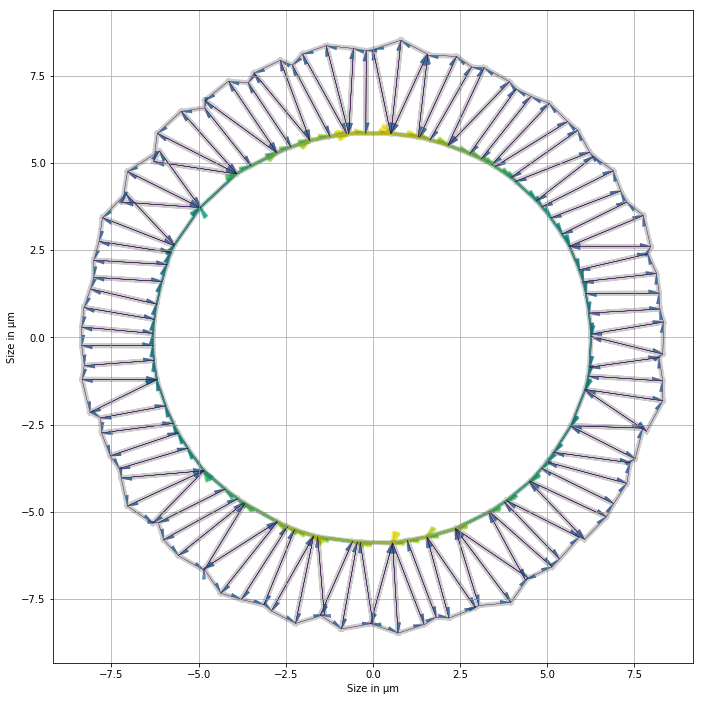

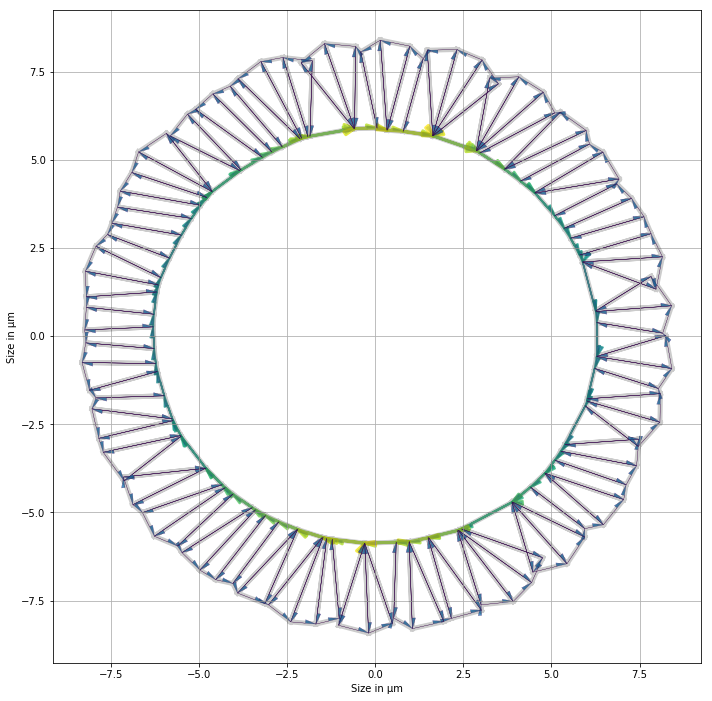

In [26]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)
dic_res = {}
for i in range(10):
    res = {}
    seed = i**2
    organo = generate_ring(100, 110, 150)
    Nf= organo.Nf
    geom.update_all(organo)
    normalize_scale(organo, geom)
    #alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


    # Model parameters or specifications
    specs = {
        'face':{
            'is_alive': 1,
            'prefered_area':  alpha*organo.face_df.area, 
            'area_elasticity': 1.,},
        'edge':{        
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert':{
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }

    organo.update_specs(specs, reset=True)
    geom.update_all(organo)

    symetric_tensions = np.multiply(set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha),
                                    np.random.normal(1, 0.05, int(organo.Ne*0.75)))
    sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
    organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
    organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
    organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

    new_tensions = organo.edge_df.line_tension

    organo.edge_df.loc[:,'line_tension'] = new_tensions

    res = Solver.find_energy_min(organo, geom, model)  
    noisy = organo.copy()
    initial_guess = infer_forces(organo, method='NNLS', compute_pressions=False)
    #initial_guess = infer_forces(organo)['tensions']
    #initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
    res['tyssue_tensions'] = organo.edge_df.line_tension
    res['force_inference_tensions'] = initial_guess['tensions']
    noisy = organo.copy()
    initial_guess = infer_forces(organo, 'NNLS', compute_pressions=False)['tensions']
    noisy_no_move = noisy.copy()
    noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
    Solver.find_energy_min(noisy_no_move, geom, model)
    print_tensions(organo, organo)
    dic_res[seed] = res
    print(i)
    

In [3]:
table_tyssue_tensions = np.concatenate([dic_res[i**2]['tyssue_tensions'][:30] for i in range(100)])
table_force_inference_tensions = np.concatenate([dic_res[i**2]['force_inference_tensions'][:30] for i in range(100)])

-0.4980618570879899


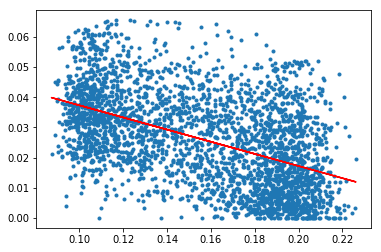

In [4]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(table_tyssue_tensions,
                                                              table_force_inference_tensions)
plt.plot(table_tyssue_tensions, table_force_inference_tensions, '.')
plt.plot(table_tyssue_tensions, intercept+slope*table_tyssue_tensions,
        'r-')
print(r_value)

In [5]:
r_value

-0.4980618570879899

In [6]:
organo.Ne

400

### Control randomness

In [26]:
def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)
seed = 1553

Generate the theoritical organoïd

In [47]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)

symetric_tensions = np.multiply(set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha),
                                np.random.normal(1,0.002,int(organo.Ne*0.75)))
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


Creating a printing function

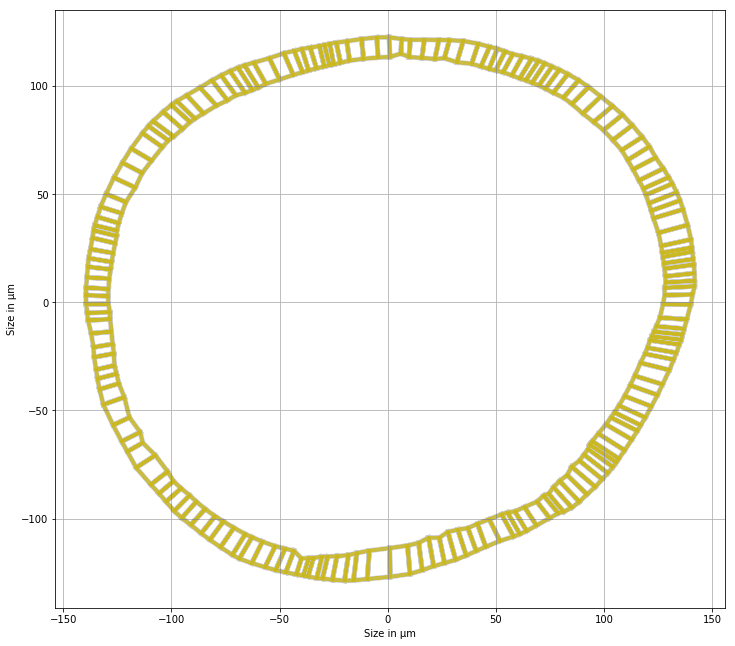

In [4]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

Define the optimization parameters

In [29]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'L-BFGS-G','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-4, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-8,'ftol': 1e-5, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

# No change

We run our optimization process without any modification between the theoritical and experimental organoids to verify if it finds the same results.

Initial point from the internship

Solving time: 3.909746000000041


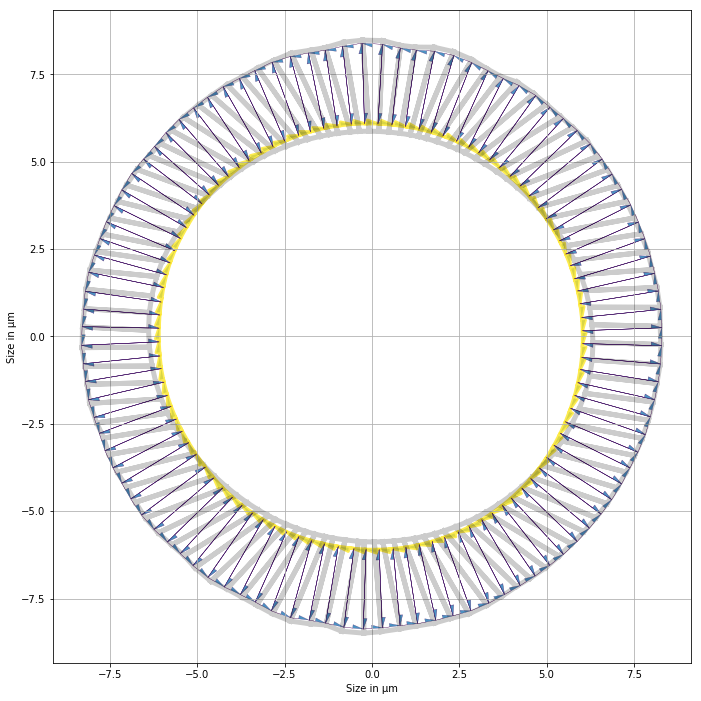

In [30]:
noisy = organo.copy()
#initial_guess = infer_forces(organo, 'QP', True)['tensions']
initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
Solver.find_energy_min(noisy_no_move, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(noisy_no_move, organo)

0.010381007598854018 0.9591667941076717 1.7462091284152464e-165
Standard deviation : 0.010381007598854018
r value : 0.9591667941076717
Distance : 108.13281823887063


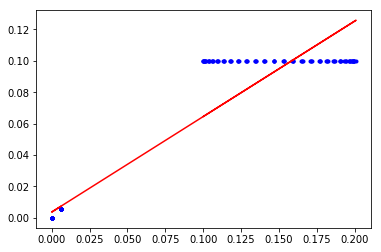

In [31]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                     np.full(initial_guess.shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf], initial_guess)
print(std_err, r_value, p_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf],initial_guess, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')
print('Standard deviation : '+str(std_err)+'\nr value : '+str(r_value)+'\nDistance : '+str(sum(_distance(organo, noisy_no_move))))

First try : we use the initial point given by the Moore-Penrose pseudo inverse and check if it fits to the real organoid.

Solving time: 29.903975000000003


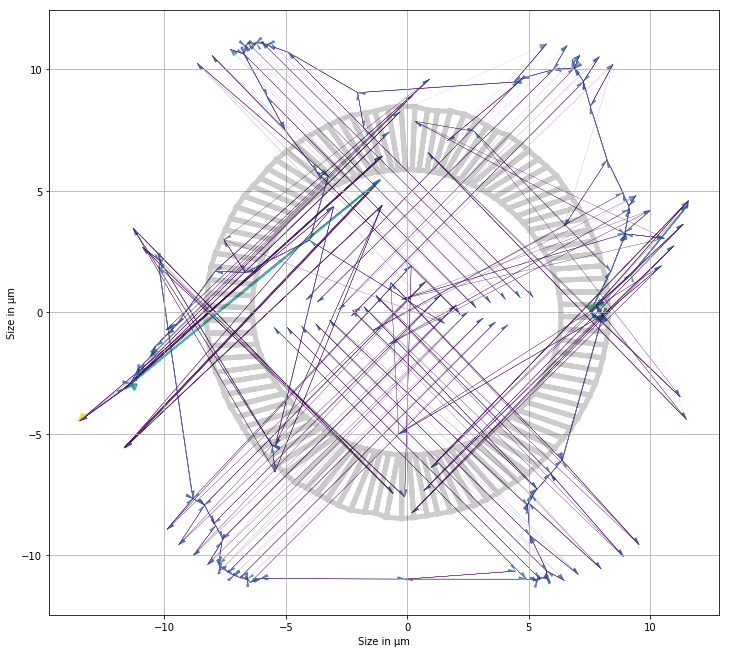

In [32]:
noisy = organo.copy()
#initial_guess = infer_forces(organo, 'QP', True)['tensions']
initial_guess = infer_forces(organo)['tensions']
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
Solver.find_energy_min(noisy_no_move, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(noisy_no_move, organo)

Standard deviation : 235.6176132484267
r value : 0.5185602883122099
Distance : 438.21168952621076


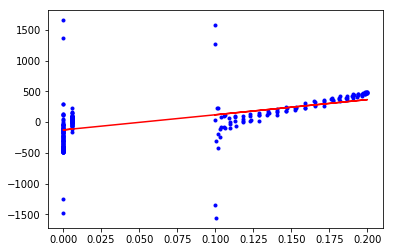

In [14]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                     np.full(initial_guess.shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf], initial_guess)

plt.plot(organo.edge_df.line_tension.values[:3*Nf],initial_guess, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')
print('Standard deviation : '+str(std_err)+'\nr value : '+str(r_value)+'\nDistance : '+str(sum(_distance(organo, noisy_no_move))))

Second try : we set the negative components of the initial point to zero

Solving time: 66.12398999999999
Tension error: [1.68999051e+02 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 3.80352470e+02 1.00000000e+00
 8.49094403e+01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


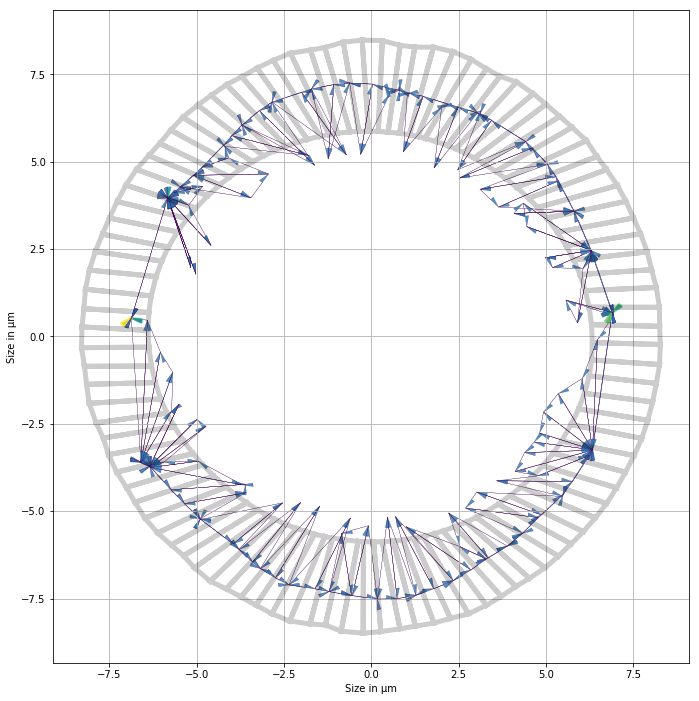

In [33]:
noisy = organo.copy()
#initial_guess = infer_forces(organo, 'QP', True)['tensions']
#initial_guess = infer_forces(organo)['tensions']
initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
#print(initial_guess)
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
Solver.find_energy_min(noisy_no_move, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_no_move, organo)

Standard deviation : 6.1377013632900415
r value : -0.34670945352512433
Distance : 216.8296560973091


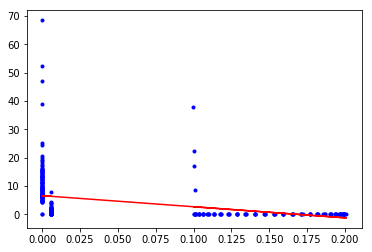

In [35]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                     np.full(initial_guess.shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf], initial_guess)

plt.plot(organo.edge_df.line_tension.values[:3*Nf],initial_guess, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')
print('Standard deviation : '+str(std_err)+'\nr value : '+str(r_value)+'\nDistance : '+str(sum(_distance(organo, noisy_no_move))))

Third try : we use a quadratic problem formulation to solve the linear system with non negative constraints on the linear tensions.

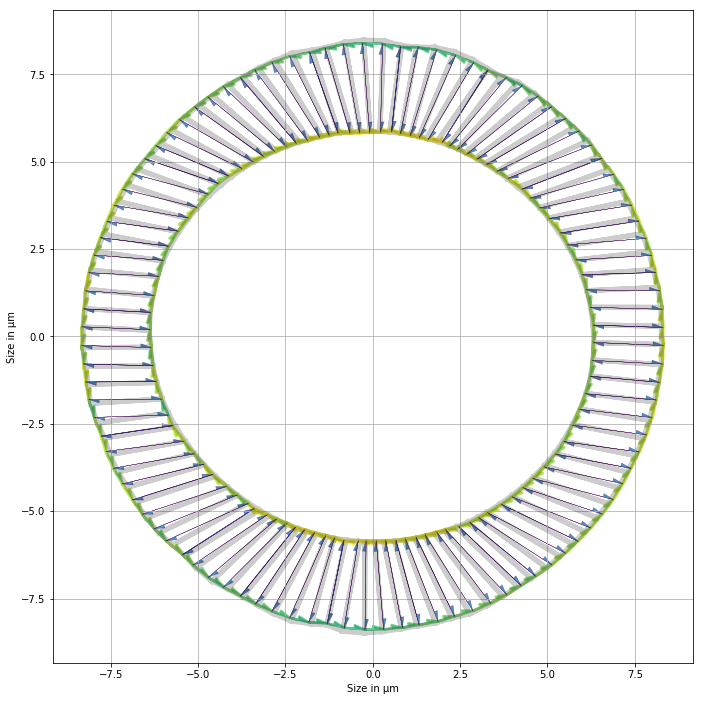

In [37]:
noisy = organo.copy()
initial_guess = infer_forces(organo, method='QP', init_method='simple', verbose=False)['tensions']
#initial_guess = infer_forces(organo)['tensions']
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
#print(initial_guess)
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
Solver.find_energy_min(noisy_no_move, geom, model)
print_tensions(noisy_no_move, organo)

Standard deviation : 0.004659890483569202
r value : 0.5413493438529151
Distance : 53.53246777120841


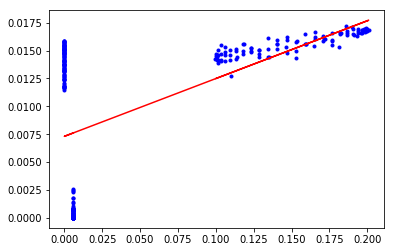

In [38]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                     np.full(initial_guess.shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf], initial_guess)

plt.plot(organo.edge_df.line_tension.values[:3*Nf],initial_guess, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')
print('Standard deviation : '+str(std_err)+'\nr value : '+str(r_value)+'\nDistance : '+str(sum(_distance(organo, noisy_no_move))))

Fourth try : we provide the Moore-Penrose result as an initial point to the quadratic formulation. 

The initial point was obtained using the Moore-Penrose               pseudo-inverse to solve the linear system proposed in the paper.              Initial point : 
 [ 1.70274832e+01 -2.14845578e+01 -1.05767245e+01 -1.44522872e+01
 -1.15592577e+01 -1.35106701e+01 -1.26826414e+01 -1.22625648e+01
 -1.16197772e+01 -1.14203602e+01 -1.13252442e+01 -1.04917103e+01
 -1.04147165e+01 -9.13524171e+00 -8.89089692e+00 -8.90844231e+00
 -8.13291066e+00 -7.26990322e+00 -7.11279266e+00 -6.81162690e+00
 -6.85018669e+00 -6.21233071e+00 -6.38993296e+00 -5.94135152e+00
 -5.99191030e+00 -6.01025673e+00 -5.87450756e+00 -5.93806355e+00
 -6.85812125e+00 -6.11294339e+00 -7.01571689e+00 -6.63628638e+00
 -7.94300916e+00 -7.66565601e+00 -9.68498609e+00 -7.37064256e+00
 -9.08174257e+00 -1.04282331e+01 -1.10031210e+01 -1.05642381e+01
 -1.05720973e+01 -1.20083472e+01 -1.41175388e+01 -1.18455956e+01
 -1.24164592e+01 -2.07275916e+01 -1.34825724e+01 -1.52799600e+01
 -2.29374551e+01 -4.64365262e+01  3.80431699e+01 -4.002

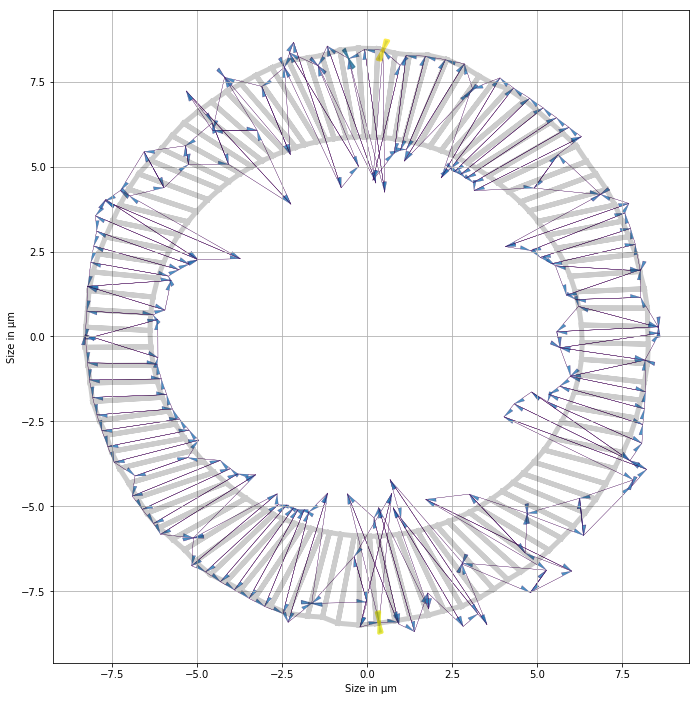

In [40]:
noisy = organo.copy()
initial_guess = infer_forces(organo, method='QP', init_method='moore-penrose', verbose=False)['tensions']
#initial_guess = infer_forces(organo)['tensions']
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
#print(initial_guess)
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
Solver.find_energy_min(noisy_no_move, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
#                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_no_move, organo)

Standard deviation : 0.046827390988969125
r value : -0.10840798498057437
Distance : 157.447661383135


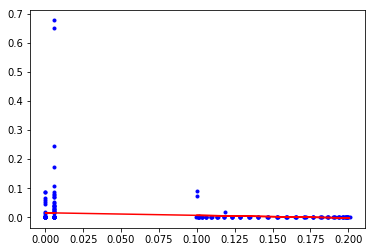

In [41]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                     np.full(initial_guess.shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf], initial_guess)

plt.plot(organo.edge_df.line_tension.values[:3*Nf],initial_guess, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')
print('Standard deviation : '+str(std_err)+'\nr value : '+str(r_value)+'\nDistance : '+str(sum(_distance(organo, noisy_no_move))))

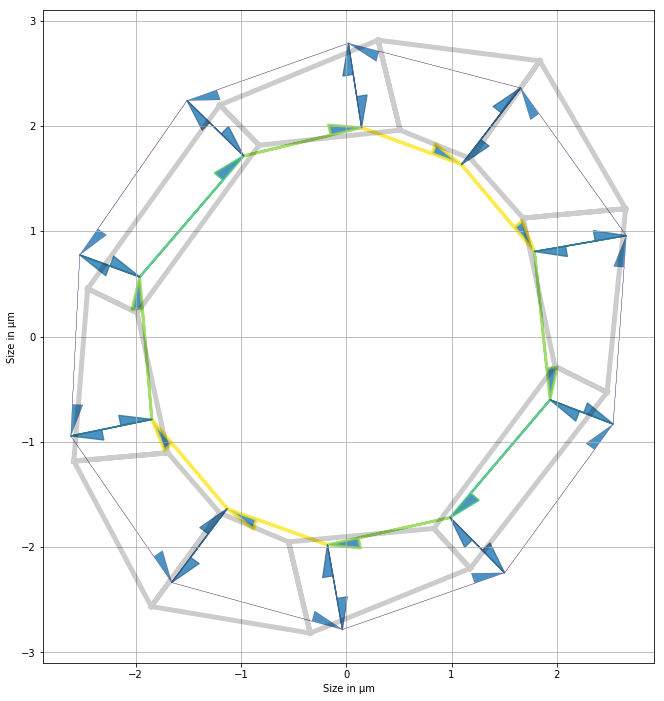

In [49]:
noisy = organo.copy()
inference = infer_forces(organo, method='NNLS', compute_pressions=False)

initial_guess = inference['tensions']
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
#print(initial_guess)
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
Solver.find_energy_min(noisy_no_move, geom, model)
print_tensions(noisy_no_move, organo)

Standard deviation : 0.0012365052669630267
r value : 0.9931904674553146
Distance : 46.656121249737566


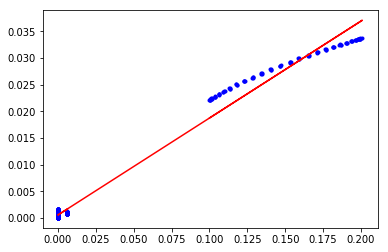

In [43]:
from scipy import stats

var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-initial_guess),
                     np.full(initial_guess.shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))

slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf], initial_guess)

plt.plot(organo.edge_df.line_tension.values[:3*Nf],initial_guess, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')
print('Standard deviation : '+str(std_err)+'\nr value : '+str(r_value)+'\nDistance : '+str(sum(_distance(organo, noisy_no_move))))

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

In [17]:
brigthfield_path = '../../assets/sample_image_brightfield.tiff'
#dapi_path = '/home/fquinton/Documents/tyssue-taylor/assets/CELLPROFILER_sample_image_dapi.tiff.csv'
dapi_path = '../../assets/sample_image_dapi.tiff'
scp_path = '../../assets/star_convex_polynoms/models'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           method='SCP',
                                                           scp_model_path=scp_path,
                                                          rol_window_inside=100,
                                                          rol_window_outside=2)
Nf = organo.Nf
geom.update_all(organo)
#normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(organo.face_df.area)*organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(organo.settings['R_in']+organo.settings['R_out']))
print(alpha)
alpha = 1.001
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

Loading network weights from 'weights_best.h5'.


Reseting datasets values with new specs


0.9999999980633865


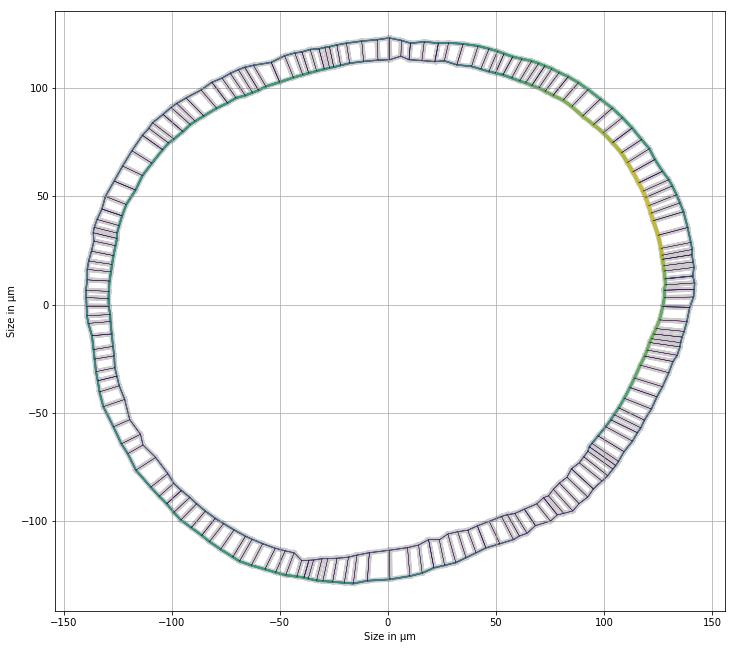

In [18]:
noisy = organo.copy()
initial_guess = infer_forces(organo, method='NNLS', compute_pressions=False, verbose=False)['tensions']
#initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
#initial_guess = np.maximum(np.zeros(int(organo.Ne*0.75)), infer_forces(organo)['tensions'])
start = time.clock()
noisy_no_move = noisy.copy()
noisy_no_move.edge_df.line_tension = prepare_tensions(noisy_no_move, initial_guess)
res = Solver.find_energy_min(noisy_no_move, geom, model)
#print(res)
print_tensions(noisy_no_move, organo)